In [21]:
import pandas as pd
import sys 
sys.path.append('../')
pd.set_option('display.max_columns', None)

from utils.processing import *
from utils.file_management import read_yaml
from utils.train import train_lightgbm_model
from utils.evaluation import mape_score
from utils.plotting import plot_feature_importance
from utils.evaluation import evaluate_test_set

from config.paths import CONFIG_PATH, PROCESSED_DATA_PATH
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

import lightgbm as lgb

# Notas
* Eliminar variables correlacionadas empeora el rendimiento tanto para training como para testing.
* 

In [22]:
df = import_raw_dataset()
features = read_yaml(f'{CONFIG_PATH}/features.yaml')

Successfully import /Users/robertogarces/data-science/projects/real-state/data/raw/RealEstate_California.csv


In [23]:
target = features['target'][0]
target

'price'

In [24]:
df = remove_duplicated_ids(df)
df = remove_price_outliers(df, lower_bound=2.5, upper_bound=97.5)

29500.0 5500000.0


In [25]:
pctg_train = 0.8
n_train = int(len(df) * pctg_train)
train_idx = df.sample(n=n_train, random_state=42).index
train = df.loc[train_idx]
test = df.loc[~df.index.isin(train_idx)]

In [26]:
train_idx

Int64Index([11623, 20094, 35289, 27607, 14422, 13527, 29286, 11156,  7968,
            11055,
            ...
            11272, 25538, 13652,  6993,  3610, 26674, 17474,  7145, 28817,
             7398],
           dtype='int64', length=23556)

# Preprocessing

In [27]:
transform_price_log = FunctionTransformer(transform_price_log, validate=False)
transform_area_units = FunctionTransformer(transform_area_units, validate=False)
categorize_bedrooms = FunctionTransformer(categorize_bedrooms, validate=False)
categorize_bathrooms = FunctionTransformer(categorize_bathrooms, validate=False)
categorize_yearBuilt = FunctionTransformer(categorize_yearBuilt, validate=False)
remove_garageSpaces_outliers = FunctionTransformer(remove_garageSpaces_outliers, validate=False)
map_levels = FunctionTransformer(map_levels, validate=False)
process_homeType = FunctionTransformer(process_homeType, validate=False)
impute_hasGarage = FunctionTransformer(impute_hasGarage, validate=False)
city_median_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'city', 'statistic': 'median'})
city_mean_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'city', 'statistic': 'mean'})
county_median_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'county', 'statistic': 'median'})
county_mean_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'county', 'statistic': 'mean'})
_5_knn_median_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':5, 'statistic':'median'})
_5_knn_mean_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':5, 'statistic':'mean'})
_25_knn_median_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':25, 'statistic':'median'})
_25_knn_mean_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':25, 'statistic':'mean'})
encoding = FunctionTransformer(encode_categorical_variables, validate=False)
drop_features = FunctionTransformer(drop_features, validate=False, kw_args={'target':target})
remove_highly_correlated_features = FunctionTransformer(remove_highly_correlated_features, validate=False, kw_args={'target':'price', 'threshold':0.9})

In [28]:
preprocessing_steps = [
    ('transform_price_log', transform_price_log),
    ('transform_area_units', transform_area_units),
    ('categorize_bedrooms', categorize_bedrooms),
    ('categorize_bathrooms', categorize_bathrooms),
    ('categorize_yearBuilt', categorize_yearBuilt),
    ('remove_garageSpaces_outliers', remove_garageSpaces_outliers),
    ('map_levels', map_levels),
    ('process_homeType', process_homeType),
    ('impute_hasGarage', impute_hasGarage),
    ('city_median_price', city_median_price),
    ('city_mean_price', city_mean_price),
    ('county_median_price', county_median_price),
    ('county_mean_price', county_mean_price),
    ('5_knn_median_price', _5_knn_median_price),
    ('5_knn_mean_price', _5_knn_mean_price),
    ('25_knn_median_price', _25_knn_median_price),
    ('25_knn_mean_price', _25_knn_mean_price),
    ('encoding', encoding),
    ('drop_features', drop_features),
  #  ('remove_highly_correlated_features', remove_highly_correlated_features)
]

# Pipelines

In [29]:
# Definir la pipeline
preprocessing_pipeline = Pipeline(preprocessing_steps)

# Aplicar la pipeline a tus datos
train_transformed = preprocessing_pipeline.fit_transform(train.copy())

train_transformed.to_parquet(f'{PROCESSED_DATA_PATH}/transformed_dataset.parquet', index=False)

In [30]:
train_transformed.head(3)

,price,city,county,lotAreaUnits,parking,garageSpaces,hasGarage,pool,spa,homeType,livingAreaMts_log,yearBuilt,city_median_price,city_mean_price,county_median_price,county_mean_price,bedrooms,mapped_levels,5_knn_mean_price,5_knn_median_price,25_knn_mean_price,25_knn_median_price
11623,1599000.0,584,18,1,0,0.0,0.0,0,0,3,7.167809,1952,1095000.0,1.366969e+06,880000.0,1.188662e+06,2.0,2,1361400.0,1299000.0,1531823.88,1300000.0
20094,509900.0,849,44,0,1,0.0,0.0,1,0,3,7.705262,1992,399900.0,4.450321e+05,304500.0,3.944190e+05,4.0,0,380980.0,385000.0,404480.00,379000.0
35289,324000.0,964,45,0,0,0.0,0.0,0,0,3,7.667158,1978,324000.0,4.411429e+05,269500.0,4.138498e+05,4.0,0,358800.0,350000.0,979512.00,449000.0


# Cluster test

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def cluster_model_feature(dataset, max_clusters, features):

    X = dataset[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    silhouette_scores = []
    for i in range(2, max_clusters + 1):  # Empezamos desde 2 clusters
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X_scaled)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(X_scaled, labels)
        silhouette_scores.append(silhouette_avg)

    # Find the optimal number of clusters
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 porque empezamos desde 2 clusters
    print(f"Optimal number of clusters: {optimal_clusters}")

    # Build and return the clustering model with the optimal number of clusters
    clustering_model = KMeans(n_clusters=optimal_clusters, random_state=42)
    clustering_model.fit(X_scaled)

    return clustering_model

In [32]:
features = train_transformed.drop(columns=target).columns
cluster_model = cluster_model_feature(train_transformed, max_clusters=8, features=features)

/Users/robertogarces/data-science/projects/real-state/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/robertogarces/data-science/projects/real-state/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/robertogarces/data-science/projects/real-state/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/robertogarces/data-science/projects/real-state/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `

Optimal number of clusters: 3


/Users/robertogarces/data-science/projects/real-state/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
def apply_cluster_model_feature(dataset, clustering_model, features):
    # Escalar las features del dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(dataset[features])

    # Obtener las predicciones de cluster
    cluster_predictions = clustering_model.predict(X_scaled)

    # Agregar las predicciones como una nueva columna al dataset
    dataset_with_clusters = dataset.copy()
    dataset_with_clusters['Cluster'] = cluster_predictions

    return dataset_with_clusters

In [36]:
train_transformed =  apply_cluster_model_feature(train_transformed, cluster_model, features)

In [38]:
train_transformed['Cluster'].value_counts()

0    13876
2     5758
1     3922
Name: Cluster, dtype: int64

# Modeling

In [39]:
model = train_lightgbm_model(train_transformed, target)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 18844, number of used features: 22
[LightGBM] [Info] Start training from score 947213.509340
RMSE: 475552
MSE : 226150161885
MAE : 256115
MeAE: 117293
MAPE: 0
R2  : 0.706


<AxesSubplot: title={'center': 'Feature Importance Plot'}, xlabel='Importance', ylabel='Feature'>

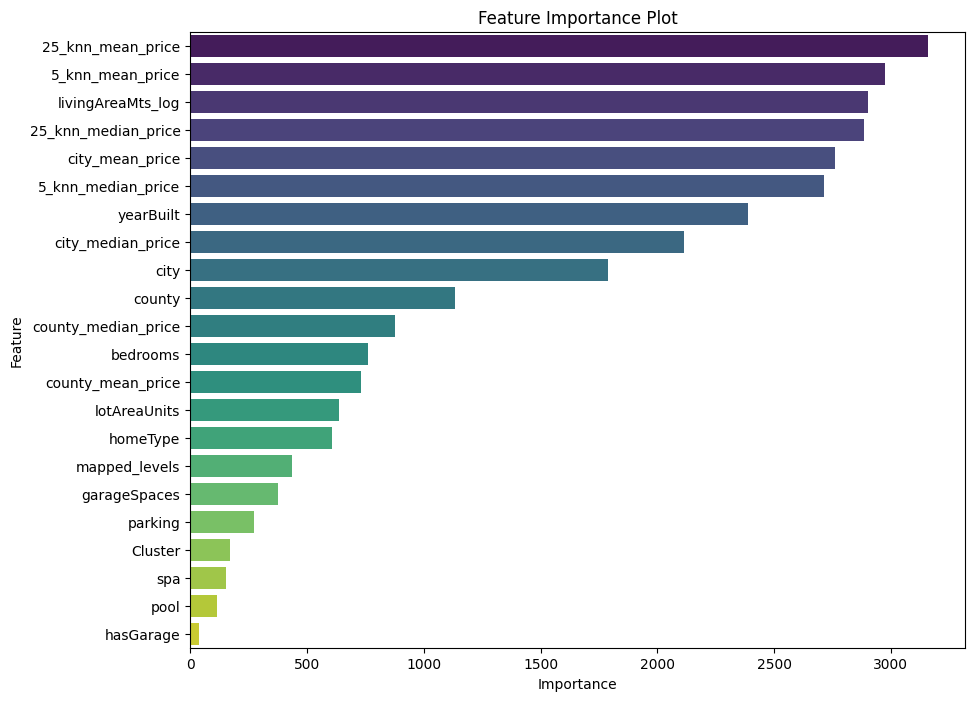

In [40]:
plot_feature_importance(model)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, scoring='neg_mean_squared_error'):
    """
    Generate learning curves for a LightGBM Regressor model.

    Parameters:
    - model: Pre-trained LightGBM Regressor model
    - X: Input features
    - y: Target variable
    - train_sizes: Array of training set sizes used to generate the learning curve
    - cv: Number of cross-validation folds
    - scoring: Scoring metric for cross-validation
    
    Returns:
    - Plots the learning curves for training and validation sets
    """

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, shuffle=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-Validation Score")

    plt.legend(loc="best")
    plt.show()

# Example Usage:
# Assuming you have a trained model 'lgbm_model' and data 'X_train', 'y_train'
# plot_learning_curve(lgbm_model, X_train, y_train)



# Evaluate on testing

In [42]:
test_transformed = preprocessing_pipeline.transform(test.copy())

In [43]:
evaluate_test_set(test_transformed, model, target, decimals=3, log_inverse_transform=True)

[LightGBM] [Fatal] The number of features in data (21) is not the same as it was in training data (22).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (21) is not the same as it was in training data (22).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

# Optuna

In [16]:
from utils.optimizer import optimize_lightgbm_params
from utils.train import train_lightgbm_model

In [17]:
train_transformed

,price,city,county,lotAreaUnits,parking,garageSpaces,hasGarage,pool,spa,homeType,livingAreaMts_log,yearBuilt,city_median_price,city_mean_price,county_median_price,county_mean_price,bedrooms,mapped_levels,5_knn_mean_price,5_knn_median_price,25_knn_mean_price,25_knn_median_price
11623,1599000.0,584,18,1,0,0.0,0.0,0,0,3,7.167809,1952,1095000.0,1.366969e+06,880000.0,1.188662e+06,2.0,2,1361400.0,1299000.0,1531823.88,1300000.0
20094,509900.0,849,44,0,1,0.0,0.0,1,0,3,7.705262,1992,399900.0,4.450321e+05,304500.0,3.944190e+05,4.0,0,380980.0,385000.0,404480.00,379000.0
35289,324000.0,964,45,0,0,0.0,0.0,0,0,3,7.667158,1978,324000.0,4.411429e+05,269500.0,4.138498e+05,4.0,0,358800.0,350000.0,979512.00,449000.0
27607,2989000.0,977,36,1,1,2.0,2.0,0,1,3,7.719574,1981,2697000.0,2.523612e+06,799000.0,1.038779e+06,3.0,2,3313400.0,3500000.0,1673488.00,1250000.0
14422,575000.0,223,54,0,0,0.0,0.0,0,0,3,8.020928,1986,319000.0,3.704286e+05,397000.0,4.800870e+05,3.0,1,129800.0,129000.0,360720.00,298000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26674,1195000.0,382,18,1,0,0.0,0.0,0,0,2,8.185350,1961,780000.0,9.490848e+05,880000.0,1.188662e+06,0.0,2,860780.0,859000.0,969948.00,850000.0
17474,362000.0,455,29,1,0,0.0,0.0,0,1,0,6.212606,1983,1149000.0,1.289253e+06,925000.0,1.225711e+06,1.0,1,1120300.0,1150000.0,1474235.96,1150000.0
7145,1248000.0,906,42,1,1,0.0,0.0,0,0,3,7.216709,1964,1175000.0,1.240153e+06,1299000.0,1.562349e+06,4.0,0,1450360.2,1325000.0,1152007.48,1228000.0
28817,899000.0,584,18,1,0,0.0,0.0,0,0,3,7.021976,1906,1095000.0,1.366969e+06,880000.0,1.188662e+06,3.0,1,1221199.0,1180000.0,1189991.76,1139000.0


In [18]:
# Uso de la función
# Supongamos que tienes un DataFrame df y el objetivo es predecir la columna 'target'
best_params = optimize_lightgbm_params(train_transformed.drop(target, axis=1), train_transformed[target], n_trials=25)
print(best_params)

[I 2024-01-04 16:41:16,634] A new study created in memory with name: no-name-f85f6bbb-5426-4c9d-866a-477bb419b6a0
/Users/robertogarces/data-science/projects/real-state/notebooks/../utils/optimizer.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
/Users/robertogarces/data-science/projects/real-state/notebooks/../utils/optimizer.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/robertogarces/data-science/projects/real-state/notebooks/../utils/optimizer.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature 

{'num_leaves': 81, 'learning_rate': 0.10088477330236008, 'feature_fraction': 0.6934717962861245, 'bagging_fraction': 0.9825748050251837, 'bagging_freq': 3, 'reg_alpha': 8.287333991270519e-09, 'reg_lambda': 1.0205850788594626e-07}


In [19]:
model = train_lightgbm_model(train_transformed, target, best_params)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2394
[LightGBM] [Info] Number of data points in the train set: 18844, number of used features: 21
[LightGBM] [Info] Start training from score 947213.509340
RMSE: 479908
MSE : 230312363410
MAE : 262444
MeAE: 121482
MAPE: 0
R2  : 0.701


In [20]:
evaluate_test_set(test_transformed, model, target)

RMSE: 481100.0
MSE : 231457329743.0
MAE : 278562.0
MeAE: 143515.0
MAPE: 1.0
R2  : 1.0
